In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import fetch_data
import numpy as np
import correct_drift
import datetime
from scipy import signal
from scipy.spatial.transform import Rotation as R
from ahrs.filters import Madgwick
from ahrs.filters import Mahony

import importlib
importlib.reload(fetch_data)

start_date_str = '2023-05-30'
end_date_str = '2023-06-01'
organization_id = 'hamid'
can_k3y_id = '9ed5b50e'
imu_k3y_id = '78f8031e'

Get the CAN Server Data

In [2]:
event_dict = fetch_data.get_events(can_k3y_id, organization_id, start_date_str, end_date_str)
can_df = fetch_data.get_can_data(can_k3y_id, organization_id, start_date_str, end_date_str)

Get the Raw IMU Data

In [3]:
raw_acc_df, raw_gyro_df = fetch_data.get_raw_data(imu_k3y_id, organization_id, start_date_str, end_date_str)
start_date = datetime.datetime.strptime(start_date_str, '%Y-%m-%d')
end_date = datetime.datetime.strptime(end_date_str, '%Y-%m-%d')
time_df = correct_drift.fetch_time_data(imu_k3y_id, organization_id, start_date, end_date)

Correct the Time For Raw Data

In [4]:
raw_acc_df = correct_drift.shift_time(raw_acc_df, time_df)
raw_gyro_df = correct_drift.shift_time(raw_gyro_df, time_df)

Define the Orientation Filter Functions

In [10]:
k3y_g = 9.81
S3_K3Y_VEH_ROT_MTX = np.array([[1, 0, 0], [0, -1, 0], [0, 0, -1]])

def calculate_rot_matrix(ac_data, gy_data, filter_params):
    madg_filter = Madgwick(acc=ac_data, gyr=gy_data, Dt=(1/filter_params['SR']), gain=filter_params['gain'],
                        q0=filter_params['init_qua'])
    quaternions = madg_filter.Q
    filter_params['init_qua'] = quaternions[-1,:]
    # converting quaternion from scalar first (AHRS library) to scalar last(SciPy)
    quaternions_scipy = np.roll(quaternions, shift=3, axis=1)
    rot_mtxs = R.from_quat(quaternions_scipy).as_matrix()

    return rot_mtxs

def gravity_compensate(ac_batch, gy_batch, madgwick_params, g=k3y_g):
    rotation_mtxs = calculate_rot_matrix(ac_batch, gy_batch, madgwick_params)
    # Rotation matrix is orthogonal, last colum = last row of the inverse
    gravity_components = g * rotation_mtxs[:,-1,:]
    ac_g_compensated = ac_batch - gravity_components

    return ac_g_compensated

def imu_k3y_to_vehicle(ac_batch_np, gy_batch_np, madgwick_params):
    g_removed_ac_np = gravity_compensate(ac_batch_np[:, 1:], gy_batch_np[:, 1:], madgwick_params, g=k3y_g)
    vehicle_ac = np.matmul(S3_K3Y_VEH_ROT_MTX, g_removed_ac_np.T)
    vehicle_ac_np = np.column_stack((ac_batch_np[:,0], vehicle_ac.T))

    vehicle_gy = np.matmul(S3_K3Y_VEH_ROT_MTX, gy_batch_np[:, 1:].T)
    vehicle_gy_np = np.column_stack((gy_batch_np[:,0], vehicle_gy.T))

    return vehicle_ac_np, vehicle_gy_np

Define the Function to Select a Batch and Perform AHRS

In [11]:
def compute_AHRS(raw_acc_df, raw_gyro_df, event_dict, madgwick_params):
    buffer = 5
    ac_dr_df_list = []
    gy_dr_df_list = []
    for state_num in range(len(event_dict['driving_state'])):
        dr_start_time = event_dict['driving_state'][state_num]['start']
        dr_end_time = event_dict['driving_state'][state_num]['end']

        # get just the data within the driving state
        ac_dr_motion = raw_acc_df[(raw_acc_df['correct_timestamp'] >= dr_start_time + buffer) 
                            & (raw_acc_df['correct_timestamp'] <= dr_end_time)]
        gy_dr_motion = raw_gyro_df[(raw_gyro_df['correct_timestamp'] >= dr_start_time + buffer) 
                            & (raw_gyro_df['correct_timestamp'] <= dr_end_time)]
        if(len(ac_dr_motion) != 0 and len(gy_dr_motion) != 0):
            # gravity compensate batch
            merged_data = pd.merge(ac_dr_motion, gy_dr_motion, on='correct_timestamp', how='inner')
            raw_acc_np = merged_data[['correct_timestamp', 'lr_acc(m/s^2)', 'bf_acc(m/s^2)', 'vert_acc(m/s^2)']].to_numpy()
            raw_gyro_np = merged_data[['correct_timestamp', 'lr_w(rad/s)', 'bf_w(rad/s)', 'vert_w(rad/s)']].to_numpy()
            corrected_acc_np, corrected_gyro_np = imu_k3y_to_vehicle(raw_acc_np, raw_gyro_np, madgwick_params)
            corrected_acc_df = pd.DataFrame(corrected_acc_np, columns=['correct_timestamp', 'lr_acc(m/s^2)', 'bf_acc(m/s^2)', 'vert_acc(m/s^2)'])
            corrected_gyro_df = pd.DataFrame(corrected_gyro_np, columns=['correct_timestamp', 'lr_w(rad/s)', 'bf_w(rad/s)', 'vert_w(rad/s)'])
            ac_dr_df_list.append(corrected_acc_df)
            gy_dr_df_list.append(corrected_gyro_df)

    acc_df = pd.concat(ac_dr_df_list, ignore_index=True)
    gyro_df = pd.concat(gy_dr_df_list, ignore_index=True)
    return acc_df, gyro_df

Plot the Data in Intervals

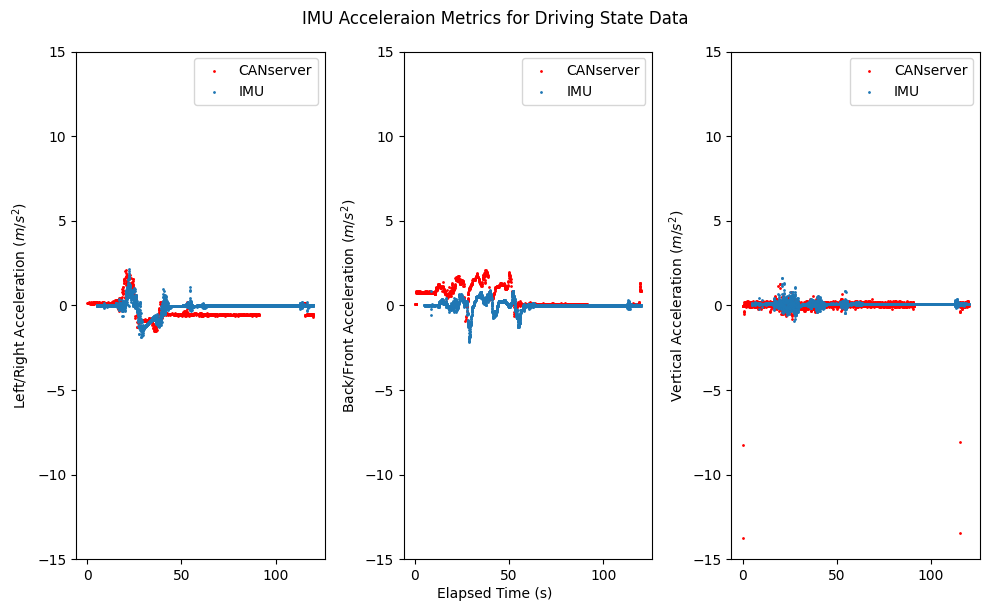

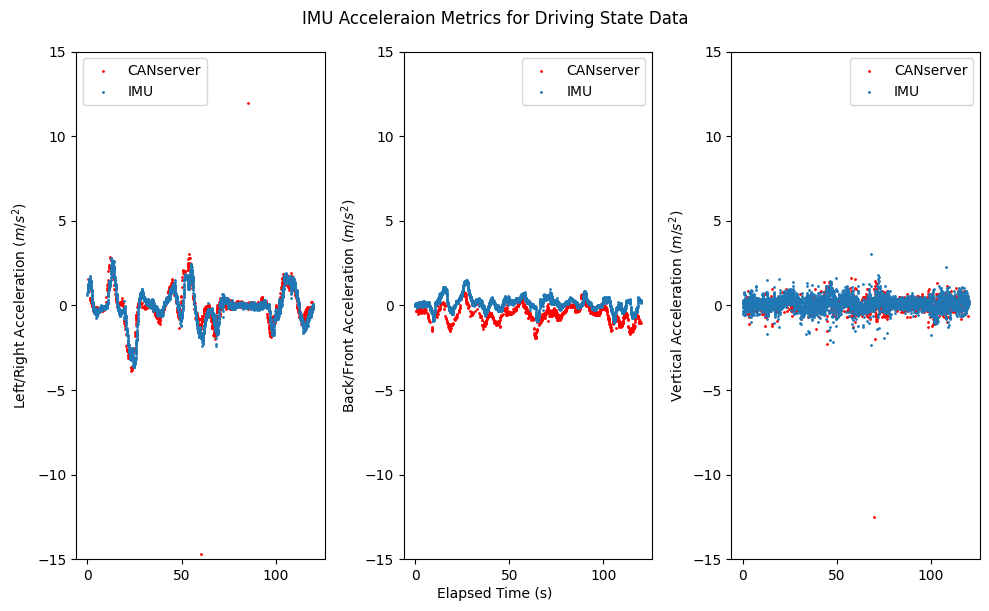

In [13]:
madgwick_params = {'SR': 100, 'gain': 0.02, 'init_qua': [0,0,0,1]}

# get the dataframe
raw_df = compute_AHRS(raw_acc_df, raw_gyro_df, event_dict, madgwick_params)[0]

window = 120
count = 0
can_df = can_df[can_df['bf_acc'].notna()]
can_df.reset_index(drop=True, inplace=True)

for state_num in range(len(event_dict['driving_state'])):
    dr_start_time = event_dict['driving_state'][state_num]['start']
    dr_end_time = event_dict['driving_state'][state_num]['end']

    while (dr_end_time - dr_start_time > window):
        dr_motion = raw_df[(raw_df['correct_timestamp'] >= dr_start_time) 
                        & (raw_df['correct_timestamp'] <= dr_start_time + window)]
        can_motion = can_df[(can_df['timestamp'] >= dr_start_time) 
                            & (can_df['timestamp'] <= dr_start_time + window)]
        dr_start_time += window

        count += 1
        if ((len(dr_motion) != 0) and (len(can_motion) != 0) and ((count == 8) or (count == 6))):
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

            fig.set_size_inches(10,6)

            lr_mean = dr_motion['lr_acc(m/s^2)'].mean()
            bf_mean = dr_motion['bf_acc(m/s^2)'].mean()
            vert_mean = dr_motion['vert_acc(m/s^2)'].mean()
            lr_can_mean = can_motion['lr_acc'].mean()
            bf_can_mean = can_motion['bf_acc'].mean()
            vert_can_mean = can_motion['vert_acc'].mean()

            ax1.scatter(x=can_motion['timestamp'] - dr_start_time + window, y=-can_motion['lr_acc'], s=1, color='red', label='CANserver')
            ax1.scatter(x=dr_motion['correct_timestamp'] - dr_start_time + window, y=dr_motion['lr_acc(m/s^2)'], s=1, label='IMU')
            ax1.set_ylim(-15,15)

            ax2.scatter(x=can_motion['timestamp'] - dr_start_time + window, y=can_motion['bf_acc'], s=1, color='red', label='CANserver')
            ax2.scatter(x=dr_motion['correct_timestamp'] - dr_start_time + window, y=dr_motion['bf_acc(m/s^2)'], s=1, label='IMU')
            ax2.set_ylim(-15,15)

            ax3.scatter(x=can_motion['timestamp'] - dr_start_time + window, y=can_motion['vert_acc'], s=1, color='red', label='CANserver')
            ax3.scatter(x=dr_motion['correct_timestamp'] - dr_start_time + window, y=dr_motion['vert_acc(m/s^2)'], s=1, label='IMU')
            ax3.set_ylim(-15,15)

            fig.suptitle("IMU Acceleraion Metrics for Driving State Data")
            fig.text(0.5, 0.0, 'Elapsed Time (s)', ha='center')

            ax1.set_ylabel("Left/Right Acceleration ($m/s^2$)")
            ax2.set_ylabel("Back/Front Acceleration ($m/s^2$)")
            ax3.set_ylabel("Vertical Acceleration ($m/s^2$)")

            ax1.legend()
            ax2.legend()
            ax3.legend()
            plt.tight_layout()
            plt.show()